# Session 3. Machine Learning for Classification

Course info: https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp

Note: it is good practice to clear the outputs before pushing, however, here the complete notebook is pushed as it is a small notebook and the goal is to see the answers to the questions.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer  # takes a dictionary and make it a vector
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import warnings
#warnings.filterwarnings("ignore")

#data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'
#!wget $data

path = "/home/mmc/Desktop/DataTalks/data/"
df_original = pd.read_csv(path + "AB_NYC_2019.csv")
df_original.head() # 48895 rows × 16 columns

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [2]:
# Selecting relevant cols
# df_original.columns
df = df_original.copy()
df = df[['neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
    'calculated_host_listings_count', 'availability_365'
    ]]

# Filling missing values with zero
# df.isnull().sum()  # reviews_per_month has 10052 nulls
df.reviews_per_month = df.reviews_per_month.fillna(0) # replace NaNs with zeros

df.head()

,neighbourhood_group,room_type,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,40.64749,-73.97237,149,1,9,0.21,6,365
1,Manhattan,Entire home/apt,40.75362,-73.98377,225,1,45,0.38,2,355
2,Manhattan,Private room,40.80902,-73.94190,150,3,0,0.00,1,365
3,Brooklyn,Entire home/apt,40.68514,-73.95976,89,1,270,4.64,1,194
4,Manhattan,Entire home/apt,40.79851,-73.94399,80,10,9,0.10,1,0


### Question 1

What is the most frequent observation (mode) for the column 'neighbourhood_group'?

In [3]:
df.mode()#dropna=False

,neighbourhood_group,room_type,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Manhattan,Entire home/apt,40.71813,-73.95677,100.0,1.0,0.0,0.0,1.0,0.0
1,NaN,NaN,NaN,-73.95427,NaN,NaN,NaN,NaN,NaN,NaN


#### Split the data
+ Split your data in train/val/test sets, with 60%/20%/20% distribution.
+ Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
+ Make sure that the target value ('price') is not in your dataframe.

### Question 2

+ Create the correlation matrix for the numerical features of your train dataset.
+ In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

What are the two features that have the biggest correlation in this dataset?


In [4]:
# make new col with price binary (see Q3) to run a logistic regression
df['above_average'] = df.price
df.above_average = (df.above_average > 151).astype(int)

# another way of binarizing the price column
# df_bin = df.copy()
# mean = df_bin['price'].mean()
# df_bin['above_average'] = np.where(df_bin['price']>=mean,1,0)  # np.where replace the 1st argument if True

df.head()

,neighbourhood_group,room_type,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,above_average
0,Brooklyn,Private room,40.64749,-73.97237,149,1,9,0.21,6,365,0
1,Manhattan,Entire home/apt,40.75362,-73.98377,225,1,45,0.38,2,355,1
2,Manhattan,Private room,40.80902,-73.94190,150,3,0,0.00,1,365,0
3,Brooklyn,Entire home/apt,40.68514,-73.95976,89,1,270,4.64,1,194,0
4,Manhattan,Entire home/apt,40.79851,-73.94399,80,10,9,0.10,1,0,0


In [5]:
# separate train + validation (= full) from the test data set
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
# now split the full into train and val, it should be the 20% of the 80%, which is 20/80=1/4=0.25
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42) 
len(df_train), len(df_val), len(df_test)

print("total df length:",  len(df))
print(len(df_train), "+", len(df_val), "+", len(df_test), '=', len(df_train) + len(df_val)+ len(df_test))

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# separate the target
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

total df length: 48895
29337 + 9779 + 9779 = 48895


In [6]:
#df_train.dtypes
numerical = ['latitude', 'longitude', 'minimum_nights', 
            'number_of_reviews', 'reviews_per_month',
             'calculated_host_listings_count', 'availability_365']
all_numerical = numerical + ['price']
matrix_corr = df_train[all_numerical].corr() 
matrix_corr # max is number_of_reviews and reviews_per_month 0.59

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
latitude,1.000000,0.080301,0.027441,-0.006246,-0.007159,0.019375,-0.005891,0.035428
longitude,0.080301,1.000000,-0.060660,0.055084,0.134642,-0.117041,0.083666,-0.146318
minimum_nights,0.027441,-0.060660,1.000000,-0.076020,-0.120703,0.118647,0.138901,0.046668
number_of_reviews,-0.006246,0.055084,-0.076020,1.000000,0.590374,-0.073167,0.174477,-0.048225
reviews_per_month,-0.007159,0.134642,-0.120703,0.590374,1.000000,-0.048767,0.165376,-0.052908
calculated_host_listings_count,0.019375,-0.117041,0.118647,-0.073167,-0.048767,1.000000,0.225913,0.053746
availability_365,-0.005891,0.083666,0.138901,0.174477,0.165376,0.225913,1.000000,0.080121
price,0.035428,-0.146318,0.046668,-0.048225,-0.052908,0.053746,0.080121,1.000000


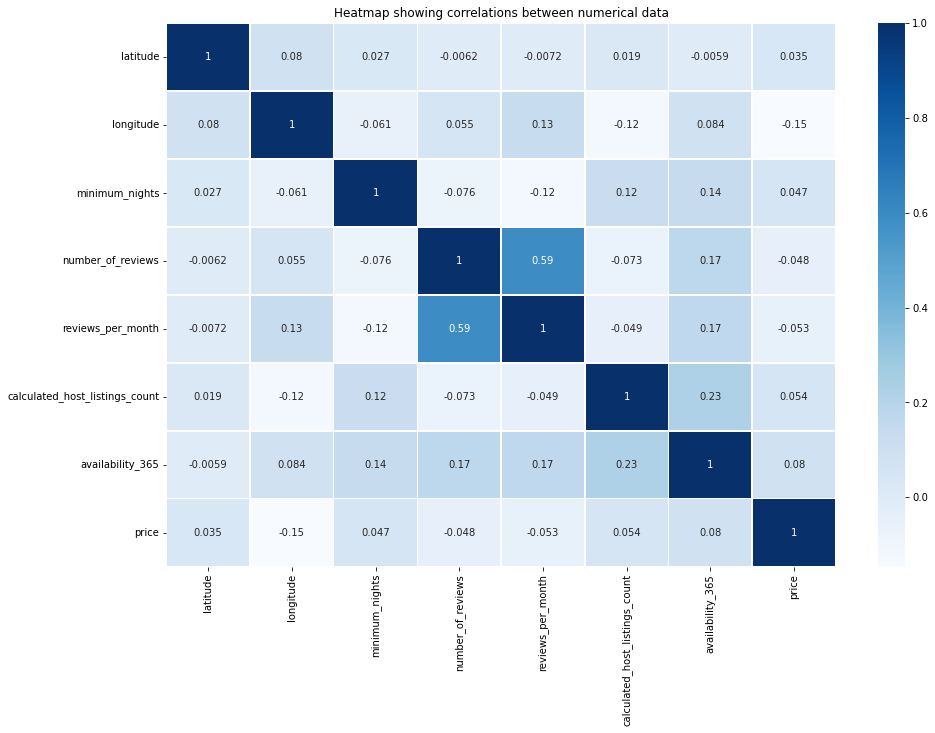

In [7]:
plt.figure(figsize=(15,10))  
sns.heatmap(matrix_corr,annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [8]:
matrix_corr.unstack().sort_values(ascending = False)[0:20]

latitude                        latitude                          1.000000
longitude                       longitude                         1.000000
availability_365                availability_365                  1.000000
calculated_host_listings_count  calculated_host_listings_count    1.000000
reviews_per_month               reviews_per_month                 1.000000
number_of_reviews               number_of_reviews                 1.000000
minimum_nights                  minimum_nights                    1.000000
price                           price                             1.000000
number_of_reviews               reviews_per_month                 0.590374
reviews_per_month               number_of_reviews                 0.590374
availability_365                calculated_host_listings_count    0.225913
calculated_host_listings_count  availability_365                  0.225913
availability_365                number_of_reviews                 0.174477
number_of_reviews        

In [9]:
# remove the non binarized target from the features (later just not include the binarized price col above_average)
del df_train['price']
del df_val['price']
del df_test['price']

#### Make price binary

We need to turn the price variable from numeric into binary.
Let's create a variable above_average which is 1 if the price is above (or equal to) 152.

NOTE: we make the binarized price col before the slipt, see Q2 above.

### Question 3

+ Calculate the mutual information score with the (binarized) price for the two categorical variables that we have. Use the training set only.
+ Which of these two variables has bigger score?
+ Round it to 2 decimal digits using round(score, 2)

In [10]:
# Mutual information - concept from information theory, 
#it tells us how much we can learn about one variable if we know the value of another

categorical = ['neighbourhood_group', 'room_type']

# define function
def mutual_info_above_average_score(series):
    return mutual_info_score(series, df_train.above_average)

# apply the function column-wise
mi = df_train[categorical].apply(mutual_info_above_average_score)
score = mi.sort_values(ascending=False) # to sort it
round(score,2)

room_type              0.14
neighbourhood_group    0.05
dtype: float64

In [11]:
# let us remove above_average from the train, val and test sets
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### Question 4


+ Now let's train a logistic regression
+ Remember that we have two categorical variables in the data. Include them using one-hot encoding.
+ Fit the model on the training dataset.
+ To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
        model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)
+ Calculate the accuracy on the validation dataset and rount it to 2 decimal digits.


In [12]:
# Include the categorical variables using OHE

dv = DictVectorizer(sparse=False) # False: not sparse matrix, that are when there are many zeros

# Train set
# make a dictionary 
train_dict = df_train[categorical + numerical].to_dict(orient='records') # records = to do it row-wise, not col-wise
# NOTE THAT HERE WE HAVE ALREADY REMOVED THE TARGET
# fit, transform, and make it a vector
X_train = dv.fit_transform(train_dict)

# Val set
# make a dict
val_dict = df_val[categorical + numerical].to_dict(orient='records')
# transform and make it a vector
X_val = dv.transform(val_dict)

In [13]:
# Fit the logistic regression model with the train data set

model = LogisticRegression(solver='liblinear', C=1.0, random_state=42)  #'lbfgs' gives TOTAL no of ITERATIONS REACHED LIMIT
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [14]:
model.intercept_[0] # the bias

-0.09189354154877066

In [15]:
model.coef_[0].round(3) # the weights

array([ 3.000e-03,  4.000e-03, -5.814e+00, -3.164e+00, -1.100e-02,
       -8.400e-02,  1.250e-01,  1.575e+00, -3.000e-02, -1.677e+00,
       -3.000e-03, -4.200e-02,  1.960e+00, -8.170e-01, -1.235e+00])

In [16]:
model.predict(X_train)   # this are the HARD PREDICTIONS, no accuracy, no certainty, we do not know the probability

array([0, 0, 0, ..., 0, 0, 1])

In [17]:
# with predict_proba we get the SOFT PROBABILITY
model.predict_proba(X_train)  # left col is neg (0 = average price above 151), right col is pos (1)

array([[0.68109331, 0.31890669],
       [0.85957037, 0.14042963],
       [0.89263581, 0.10736419],
       ...,
       [0.9036206 , 0.0963794 ],
       [0.98220345, 0.01779655],
       [0.39465977, 0.60534023]])

In [18]:
# the same with the validation set, and take the 2nd col, the price above average
y_pred = model.predict_proba(X_val)[:, 1]  # soft predictions
y_pred

array([0.02879201, 0.59586002, 0.42623611, ..., 0.11418139, 0.03457918,
       0.52849798])

In [19]:
# ACCURACY
# we do not use RMSE here, we use accuracy: how many correct predictions we did?
# we evaluate the differences btw y_pred and y_val
price_decision = (y_pred >= 0.5) # we choose 0.5, meaning:
# if the probability of price being above 151 is above 0.5, we take it as predicted above 151
original_accuracy = (price_decision == y_val).mean().round(6)
(price_decision == y_val).mean().round(2)

0.79

In [20]:
# in other words:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = price_decision.astype(int)
df_pred['actual'] = y_val
df_pred['correct'] = df_pred.prediction == df_pred.actual
print(df_pred.correct.mean().round(2))
df_pred.head()

0.79


,probability,prediction,actual,correct
0,0.028792,0,0,True
1,0.595860,1,0,False
2,0.426236,0,1,False
3,0.074939,0,0,True
4,0.811812,1,1,True


### Question 5

We have 9 features: 7 numerical features and 2 categorical.Let's find the least useful one using the feature elimination technique.
    
+ Train a model with all these features (using the same parameters as in Q4).
    
+ Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
    
+ For each feature, calculate the difference between the original accuracy and the accuracy without the feature.
    
+ Which of following feature has the smallest difference?
        neighbourhood_group
        room_type
        number_of_reviews
        reviews_per_month

Note: the difference doesn't have to be positive


In [21]:
all_features = categorical + numerical
all_scores = list()
all_scores_dict = {}
print("Original accuracy:",original_accuracy)
print()

for i in range(len(all_features)):
    selec_features = list(all_features)
    selec_features = selec_features[:i] + selec_features[i+1 :]

    # Train set
    # make a dictionary 
    train_dict = df_train[selec_features].to_dict(orient='records') # records = to do it row-wise, not col-wise
    # fit, transform and make it a vector
    X_train = dv.fit_transform(train_dict)

    # VAL set
    # make a dict
    val_dict = df_val[selec_features].to_dict(orient='records')
    # transform and make it a vector
    X_val = dv.transform(val_dict)

    # Fit the logistic regression model with the train data set

    model = LogisticRegression(solver='liblinear', C=1.0, random_state=42)  
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1] # soft probability

    price_decision = (y_pred >= 0.5) # we choose 0.5, meaning:
    # if the probability of price being above 151 is above 0.5, we take it as predicted above 151
    score = (price_decision == y_val).mean().round(6)
    all_scores.append(score)
    print("removing", all_features[i],"the score is", score) 
    print("original accuracy - accuracy without the feature", (original_accuracy - score).round(6))
    print()
    all_scores_dict[all_features[i]] = score

#print(all_scores_dict)

Original accuracy: 0.790776

removing neighbourhood_group the score is 0.749872
original accuracy - accuracy without the feature 0.040904

removing room_type the score is 0.728807
original accuracy - accuracy without the feature 0.061969

removing latitude the score is 0.786788
original accuracy - accuracy without the feature 0.003988

removing longitude the score is 0.786993
original accuracy - accuracy without the feature 0.003783

removing minimum_nights the score is 0.791492
original accuracy - accuracy without the feature -0.000716

removing number_of_reviews the score is 0.791185
original accuracy - accuracy without the feature -0.000409

removing reviews_per_month the score is 0.788935
original accuracy - accuracy without the feature 0.001841

removing calculated_host_listings_count the score is 0.789447
original accuracy - accuracy without the feature 0.001329

removing availability_365 the score is 0.781164
original accuracy - accuracy without the feature 0.009612



number_of_reviews has the smallest difference, to remove it barely affects the model accuracy.

### Question 6

For this question, we'll see how to use a linear regression model from Scikit-Learn.

+ We'll need to use the original column 'price'. Apply the logarithmic transformation to this column.
+ Fit the Ridge regression model on the training data.
+ This model has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10]
+ Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

If there are multiple options, select the smallest alpha.

NOTE: this last question is made in a self-substainable cell, i.e., it can be run independently of the rest nb, just the load cell must be run.

In [22]:
df_linear = df_original.copy()

# Select relevant cols
categorical = ['neighbourhood_group', 'room_type']
numerical = ['latitude', 'longitude', 'minimum_nights', 
             'number_of_reviews', 'reviews_per_month',
             'calculated_host_listings_count', 'availability_365']
target = ['price'] 
all_cols = categorical + numerical + target

df_linear = df_linear[all_cols]

# Replace NaNs with zeros
df_linear.reviews_per_month = df_linear.reviews_per_month.fillna(0) 

# Separate train + validation (= full) from the test data set
df_full_train, df_test = train_test_split(df_linear, test_size=0.2, random_state=42)
# Now split the full into train and val, it should be the 20% of the 80%, which is 20/80=1/4=0.25
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42) 
len(df_train), len(df_val), len(df_test)

# check dimensions
print("total df length:",  len(df_linear))
print(len(df_train), "+", len(df_val), "+", len(df_test), '=', len(df_train) + len(df_val)+ len(df_test))

# Reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# OHE for categorical features
dv = DictVectorizer(sparse=False) # False: not sparse matrix, that are when there are many zeros
# Train set
# make a dictionary 
train_dict = df_train[categorical + numerical].to_dict(orient='records') # records = to do it row-wise, not col-wise
# fit, transform, and make it a np array
X_train = dv.fit_transform(train_dict)

# Val set
# make a dict
val_dict = df_val[categorical + numerical].to_dict(orient='records')
# transform and make it a np array
X_val = dv.transform(val_dict)

# Separate the target, make np array and log transform
y_train = df_train.price.values
y_val = df_val.price.values
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)

# Fit the linear regression Ridge wth different regularization parameters (alphas)
alphas = [0, 0.01, 0.1, 1, 10]
errors = []

for a in alphas:
    model = Ridge(alpha=a, random_state=42)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_val)
    errors.append(mean_squared_error(y_predict,y_val,squared=False).round(3))
    
print(errors)

total df length: 48895
29337 + 9779 + 9779 = 48895
[0.497, 0.497, 0.497, 0.497, 0.498]


Regularization is not worth it here, all alphas give more or less the same RMSE, the smallest alpha is 0.